In [1]:
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from pathlib import Path
from torch import tensor,nn
import torch.nn.functional as F
from fastcore.test import test_close
 
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

path_data = Path('data')
path_gz = path_data/'mnist.pkl.gz'
with gzip.open(path_gz, 'rb') as f: ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
x_train, y_train, x_valid, y_valid = map(tensor, [x_train, y_train, x_valid, y_valid])

 ## Data


In [2]:
n, m = x_train.shape
c = y_train.max()+1
nh = 50
n, m, c

(50000, 784, tensor(10))

In [3]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.layers = [nn.Linear(n_in,nh), nn.ReLU(), nn.Linear(nh, n_out)]
    def forward(self, x):
        for l in self.layers:
            x = l(x)
        return x

In [4]:
model = Model(m, nh, c)
pred = model(x_train)
pred.shape

torch.Size([50000, 10])

## Basic training loop

In [34]:
loss_func = F.cross_entropy

In [16]:
bs =64

xb = x_train[0:bs]
preds = model(xb)
preds[0], preds.shape

NameError: name 'model' is not defined

In [7]:
yb = y_train[0:bs]
loss_func(preds, yb)

tensor(2.30, grad_fn=<NllLossBackward0>)

In [8]:
preds.argmax(dim=1)

tensor([3, 9, 3, 8, 5, 9, 3, 9, 3, 9, 5, 3, 9, 9, 3, 9, 9, 5, 8, 7, 9, 5, 3, 8, 9, 5, 9, 5, 5, 9, 3, 5, 9, 7, 5, 7, 9, 9, 3, 9, 3, 5, 3, 8,
        3, 5, 9, 5, 9, 5, 3, 9, 3, 8, 9, 5, 9, 5, 9, 5, 8, 8, 9, 8])

In [3]:
def accuracy(out, yb):
    return (out.argmax(dim=1)==yb).float().mean()

In [29]:
lr = 0.5
epochs = 3

In [4]:
def report(loss, preds, yb):
    print(f'{loss:.2f}, {accuracy(preds, yb):.2f}')

In [12]:
for epoch in range(epochs):
    for i in range(0, n, bs):
        s = slice(i, min(n,i+bs))
        xb, yb = x_train[s], y_train[s]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        with torch.no_grad():
            for l in model.layers:
                if hasattr(l, 'weight'):
                    l.weight -= l.weight.grad * lr
                    l.bias -= l.bias.grad * lr
                    l.weight.grad.zero_()
                    l.bias.grad.zero_()
    report(loss, preds, yb)

0.19, 0.94
0.05, 1.00
0.03, 1.00


## Using parameters and optim

### Parameters

In [13]:
m1 = nn.Module()
m1.foo = nn.Linear(3,4)

In [14]:
m1

Module(
  (foo): Linear(in_features=3, out_features=4, bias=True)
)

In [15]:
list(m1.named_children())

[('foo', Linear(in_features=3, out_features=4, bias=True))]

In [16]:
list(m1.parameters())

[Parameter containing:
 tensor([[ 0.57,  0.43, -0.30],
         [ 0.13, -0.32, -0.24],
         [ 0.51,  0.04,  0.22],
         [ 0.13, -0.17, -0.24]], requires_grad=True),
 Parameter containing:
 tensor([-0.01, -0.51, -0.39,  0.56], requires_grad=True)]

In [17]:
class MLP(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.l1 = nn.Linear(n_in, nh)
        self.l2 = nn.Linear(nh, n_out)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        return self.l2(self.relu(self.l1(x)))
    

In [18]:
model = MLP(m, nh, 10)
model.l1

Linear(in_features=784, out_features=50, bias=True)

In [19]:
model

MLP(
  (l1): Linear(in_features=784, out_features=50, bias=True)
  (l2): Linear(in_features=50, out_features=10, bias=True)
  (relu): ReLU()
)

In [20]:
for name,l in model.named_children():
    print(f"{name}: {l}")

l1: Linear(in_features=784, out_features=50, bias=True)
l2: Linear(in_features=50, out_features=10, bias=True)
relu: ReLU()


In [21]:
for p in model.parameters():
    print(p.shape)

torch.Size([50, 784])
torch.Size([50])
torch.Size([10, 50])
torch.Size([10])


In [22]:
F.linear??

In [22]:
def fit():
    for epoch in range(epochs):
        for i in range(0, n, bs):
            s = slice(i, min(n, i+bs))
            xb, yb = x_train[s], y_train[s]
            preds = model(xb)
            loss = loss_func(preds, yb)
            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()
        report(loss, preds, yb)

In [23]:
fit()

0.41, 0.94
0.10, 1.00
0.05, 1.00


In [24]:
class MyModule():
    def __init__(self, n_in, nh, n_out):
        self._modules = {}
        self.l1 = nn.Linear(n_in, nh)
        self.l2 = nn.Linear(nh, n_out)
    
    def __setattr__(self, k, v):
        if not k.startswith("_"):
            self._modules[k] = v
        super().__setattr__(k,v)
    
    def __repr__(self):
        return f'{self._modules}'
    
    def parameters(self):
        for l in self._modules.values():
            #for p in l.parameters():
            #    yield p
            yield from l.parameters()

In [25]:
mdl = MyModule(m, nh, 10)
mdl

{'l1': Linear(in_features=784, out_features=50, bias=True), 'l2': Linear(in_features=50, out_features=10, bias=True)}

In [26]:
for p in mdl.parameters():
    print(p.shape)

torch.Size([50, 784])
torch.Size([50])
torch.Size([10, 50])
torch.Size([10])


## Registering modules

In [27]:
from functools import reduce

In [28]:
layers = [nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh,10)]

In [29]:
class Model(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = layers
        for i,l in enumerate(self.layers):
            self.add_module(f'layer_{i}',l)
            
        def forward(self, x):
            return reduce(lambda val,layer: layer(val),self.layers, x)

In [30]:
model = Model(layers)
model

Model(
  (layer_0): Linear(in_features=784, out_features=50, bias=True)
  (layer_1): ReLU()
  (layer_2): Linear(in_features=50, out_features=10, bias=True)
)

In [31]:
class SequentialModel(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        
    def forward(self, x):
        for l in self.layers:
            x = l(x)
        return x

In [32]:
model = SequentialModel(layers)
model

SequentialModel(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)

In [33]:
fit()
loss_func(model(xb), yb), accuracy(model(xb),yb) 

0.17, 0.94
0.11, 1.00
0.03, 1.00


(tensor(0.01, grad_fn=<NllLossBackward0>), tensor(1.))

## nn.Sequential

In [34]:
model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10))

In [35]:
fit()
loss_func(model(xb), yb), accuracy(model(xb),yb) 

0.19, 0.94
0.14, 0.94
0.09, 0.94


(tensor(0.01, grad_fn=<NllLossBackward0>), tensor(1.))

In [36]:
model

Sequential(
  (0): Linear(in_features=784, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=10, bias=True)
)

## optim

In [5]:
class Optimizer():
    def __init__(self, params, lr = 0.5):
        self.params , self.lr = list(params), lr
        
    def step(self):
        with torch.no_grad():
            for p in self.params: p-= p.grad * self.lr
                
    def zero_grad(self):
        for p in self.params:
            p.grad.data.zero_()

In [38]:
model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10))

In [39]:
opt = Optimizer(model.parameters())

In [40]:
for epoch in range(epochs):
    for i in range(0, n, bs):
        s = slice(i, min(n,i+bs))
        xb, yb  = x_train[s], y_train[s]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
    report(loss, preds, yb)

0.16, 0.94
0.15, 0.94
0.08, 1.00


In [7]:
from torch import optim

In [53]:
def get_model():
    model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10))
    return model, optim.SGD(model.parameters(), lr=lr)

In [43]:
model, opt = get_model()
loss_func(model(xb), yb)

tensor(2.32, grad_fn=<NllLossBackward0>)

In [44]:
for epoch in range(epochs):
    for i in range(0, n, bs):
        s = slice(i, min(n,i+bs))
        xb,yb = x_train[s], y_train[s]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
    report(loss, preds, yb)

0.23, 0.94
0.12, 1.00
0.15, 0.94


In [12]:
class Dataset():
    def __init__(self, x, y):
        self.x, self.y = x, y
    def __len__(self):
        return len(self.x)
    def __getitem__(self, i):
        return self.x[i], self.y[i]

In [13]:
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)
assert len(train_ds) == len(x_train)
assert len(valid_ds) == len(x_valid)

In [47]:
xb, yb = train_ds[0:5]
assert xb.shape==(5,28*28)
assert yb.shape==(5,)

In [48]:
model,opt = get_model()

In [49]:
for epoch in range(epochs):
    for i in range(0, n, bs):
        xb,yb = train_ds[i:min(n,i+bs)]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
    report(loss, preds, yb)

0.27, 0.94
0.13, 0.94
0.20, 0.94


In [50]:
class Dataloader():
    def __init__(self, ds, bs):
        self.ds, self.bs = ds, bs
    def __iter__(self):
        for i in range(0, len(self.ds), self.bs):
            yield self.ds[i:i+self.bs]

In [51]:
train_dl = Dataloader(train_ds, bs)
valid_dl = Dataloader(valid_ds, bs)

In [52]:
xb, yb = next(iter(valid_dl))
xb.shape

torch.Size([64, 784])

In [53]:
yb

tensor([3, 8, 6, 9, 6, 4, 5, 3, 8, 4, 5, 2, 3, 8, 4, 8, 1, 5, 0, 5, 9, 7, 4, 1, 0, 3, 0, 6, 2, 9, 9, 4, 1, 3, 6, 8, 0, 7, 7, 6, 8, 9, 0, 3,
        8, 3, 7, 7, 8, 4, 4, 1, 2, 9, 8, 1, 1, 0, 6, 6, 5, 0, 1, 1])

tensor(3)

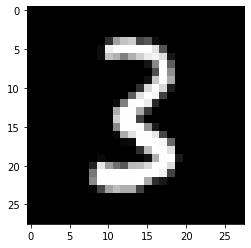

In [54]:
plt.imshow(xb[0].view(28,28))
yb[0]

In [55]:
model, opt = get_model()

In [39]:
def fit():
    for epoch in range(epochs):
        for xb,yb in train_dl:
            pred = model(xb)
            loss = loss_func(pred, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
        report(loss, pred, yb)

In [40]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

0.40, 0.94
0.13, 0.94
0.18, 0.94


NameError: name 'yb' is not defined

## random sampling

In [58]:
import random

In [59]:
class Sampler():
    def __init__(self, ds, shuffle=False):
        self.n, self.shuffle = len(ds), shuffle
        
    def __iter__(self):
        res = list(range(self.n))
        if self.shuffle:
            random.shuffle(res)
        return iter(res)

In [60]:
from itertools import islice

In [61]:
ss = Sampler(train_ds)

In [62]:
it = iter(ss)
for o in range(5):
    print(next(it))

0
1
2
3
4


In [63]:
list(islice(ss,5))

[0, 1, 2, 3, 4]

In [64]:
ss = Sampler(train_ds, shuffle=True)
list(islice(ss, 5))

[15853, 1443, 28836, 13116, 30204]

In [65]:
list(islice(ss, 5))

[25744, 29528, 1475, 25323, 22573]

In [66]:
import fastcore.all as fc

In [67]:
class BatchSampler():
    def __init__(self, sampler, bs, drop_last = False):
        self.sampler, self.bs, self.drop_last = sampler, bs, drop_last
        
    def __iter__(self):
        yield from fc.chunked(iter(self.sampler), self.bs, drop_last = self.drop_last)

In [68]:
batchs = BatchSampler(ss, 4)
list(islice(batchs,5))

[[31068, 3947, 30666, 43437],
 [46873, 48618, 15049, 46682],
 [18183, 12048, 6591, 24093],
 [33071, 8420, 41025, 34686],
 [31527, 12430, 40512, 18982]]

In [70]:
fc.chunked??

In [20]:
def collate(b):
    xs, ys = zip(*b)
    return torch.stack(xs), torch.stack(ys)

In [70]:
class Dataloader():
    def __init__(self, ds, batchs, collate_fn=collate):
        fc.store_attr()
    def __iter__(self):
        yield from (self.collate_fn(self.ds[i] for i in b) for b in self.batchs)

In [71]:
train_samp = BatchSampler(Sampler(train_ds, shuffle=True), bs)
valid_samp = BatchSampler(Sampler(valid_ds, shuffle=False), bs)

In [72]:
train_dl = Dataloader(train_ds, batchs=train_samp)
valid_dl = Dataloader(valid_ds, batchs=valid_samp)

tensor(3)

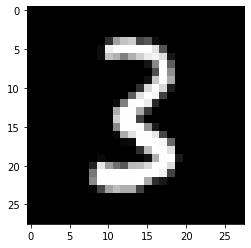

In [73]:
xb, yb = next(iter(valid_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

## Multiprocessing dataloader

In [76]:
import torch.multiprocessing as mp
from fastcore.basics import store_attr

In [77]:
train_ds[[3,6,8,1]]

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([1, 1, 1, 0]))

In [79]:
train_ds.__getitem__([3,6,8,1])

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([1, 1, 1, 0]))

In [82]:
for o in map(train_ds.__getitem__, (([3,6]),([8,1])) ):
    print (o)

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([1, 1]))
(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([1, 0]))


In [83]:
class Dataloader():
    def __init__(self, ds, batchs, n_workers=1, collate_fn=collate):
        fc.store_attr()
    def __iter__(self):
        with mp.Pool(self.n_workers) as ex:
            yield from ex.map(self.ds.__getitem__, iter(self.batchs))        

In [84]:
train_dl = Dataloader(train_ds, batchs=train_samp, n_workers=2)
it = iter(train_dl)

In [85]:
xb, yb = next(it)
xb.shape, yb.shape

(torch.Size([64, 784]), torch.Size([64]))

## Pytorch dataloader

In [41]:
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler, BatchSampler
bs =64
lr = .5

In [42]:
train_samp = BatchSampler(RandomSampler(train_ds), bs, drop_last=False)
valid_samp = BatchSampler(SequentialSampler(valid_ds), bs, drop_last=False)

In [59]:
train_dl = DataLoader(train_ds, batch_sampler=train_samp, collate_fn=collate)
valid_dl = DataLoader(valid_ds, batch_sampler=valid_samp, collate_fn=collate)

In [60]:
model, opt = get_model()
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

0.06, 1.00
0.05, 1.00
0.20, 0.88


(tensor(0.00, grad_fn=<NllLossBackward0>), tensor(1.))

In [45]:
train_dl = DataLoader(train_ds, bs, sampler=RandomSampler(train_ds), collate_fn=collate)
valid_dl = DataLoader(valid_ds, bs, sampler=SequentialSampler(valid_ds), collate_fn=collate)

In [61]:
train_dl = DataLoader(train_ds, bs, shuffle=True, collate_fn=collate)
valid_dl = DataLoader(valid_ds, bs, shuffle=False, collate_fn=collate)

In [62]:
model, opt = get_model()
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

0.12, 1.00
0.60, 0.88
0.04, 1.00


(tensor(0.00, grad_fn=<NllLossBackward0>), tensor(1.))

#### we can skip batch sampler and collate_fn entirely

In [65]:
#put batchsampler as if it was a sampler
train_dl = DataLoader(train_ds, sampler=train_samp)
valid_dl = DataLoader(valid_ds, sampler=valid_samp)

In [67]:
xb,yb = next(iter(train_dl))
xb.shape, yb.shape

(torch.Size([1, 64, 784]), torch.Size([1, 64]))

## Validation

You **always** should also have a [validation set](http://www.fast.ai/2017/11/13/validation-sets/), in order to identify if you are overfitting.

We will calculate and print the validation loss at the end of each epoch.

(Note that we always call `model.train()` before training, and `model.eval()` before inference, because these are used by layers such as `nn.BatchNorm2d` and `nn.Dropout` to ensure appropriate behaviour for these different phases.)

In [69]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb,yb in train_dl:
            loss = loss_func(model(xb), yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
            
        model.eval()
        with torch.no_grad():
            tot_loss, tot_acc,count = 0., 0., 0
            for xb,yb in valid_dl:
                pred = model(xb)
                n = len(xb)
                count += n
                tot_loss += loss_func(pred, yb).item()*n
                tot_acc += accuracy(pred, yb).item()*n
        print(epoch, tot_loss/count, tot_acc/count)
    return tot_loss/count, tot_acc/count

In [72]:
def get_dls(train_ds, valid_ds, bs, **kwargs):
    return(DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
            DataLoader(valid_ds, batch_size=bs*2, **kwargs))

In [73]:
train_dl, valid_dl = get_dls(train_ds, valid_ds, bs)
model, opt = get_model()
loss, acc = fit(5, model, loss_func, opt, train_dl, valid_dl)

0 0.1619500123798847 0.9529
1 0.14294969681203365 0.9613
2 0.11029258045330644 0.9678
3 0.2596742490440607 0.9309
4 0.1055386916257441 0.9708
